# Rice Dataset ( WIP )

https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

# 1. Importing Packages

In [163]:
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import scipy as scipy
import numpy as np

import PIL
import pathlib
import splitfolders

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 2. Initial Data Exploration

In [164]:
# Creating a list with all the paths to the images
rice_name_array = ['Karacadag','Ipsala','Arborio','Basmati','Jasmine']
all_paths = list()
all_names = list()
for rice_name in rice_name_array:
    print(rice_name)
    for image_name in os.listdir('notebooks/rice_dataset/' + rice_name):
        all_paths.append('notebooks/rice_dataset/'+ rice_name + '/' + image_name)
        all_names.append(rice_name)
    

Karacadag
Ipsala
Arborio
Basmati
Jasmine


<AxesSubplot: >

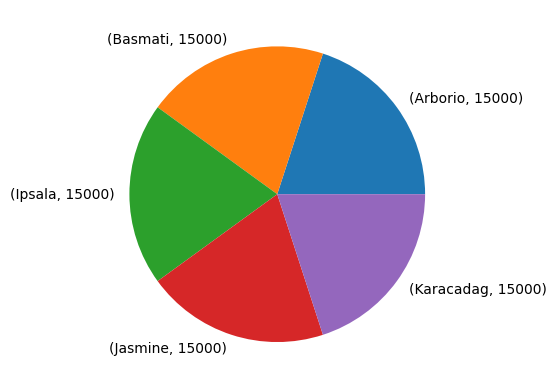

In [165]:
# Distribution of the rice types

rice_type_count_array = list()
for name in rice_name_array:
    count_of_rice_type = len([x for x in all_paths if name in x])
    rice_type_count_array.append(count_of_rice_type)

rice_count_df = pd.DataFrame([rice_name_array,rice_type_count_array])
rice_count_df.T.value_counts().plot(kind = 'pie')

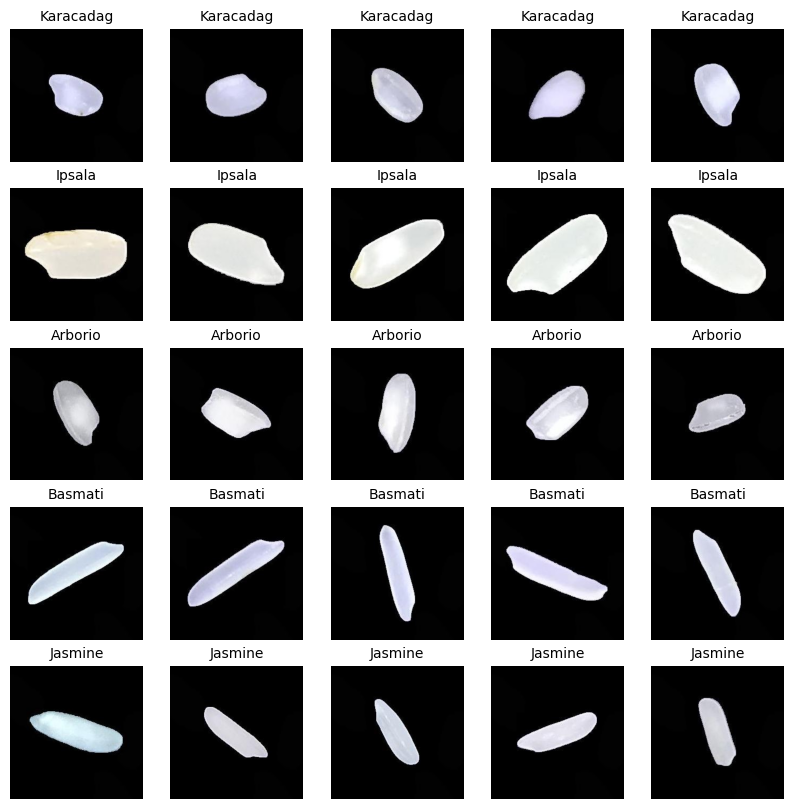

In [166]:
# Illustrating the 5 various rice sorts.
figure, ax = plt.subplots(5,5, figsize=(10, 10))
i = 0
for name in rice_name_array:
    rice_images = [x for x in all_paths if name in x][:5]
    for g in rice_images:
        image = load_img(g)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(name,fontsize=10)
        i = i + 1

(250, 250, 3)

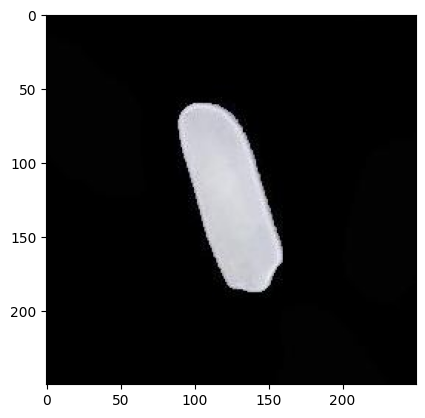

In [167]:
# Checking image size. 
plt.imshow(image)
np.asarray(image).shape

# 3. Model Creation

## 3.1 Data Preprocessing

In [162]:
# Splitting the data for training, validation and finally testing.
# 70% for training, 15% for validation, 15% for testing
parent_directory = 'notebooks/rice_dataset'
splitfolders.ratio(parent_directory, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)


KeyboardInterrupt



In [168]:
batch_size = 128
img_height, img_width = 175, 175 
input_shape = (img_height, img_width, 3)


datagen = ImageDataGenerator(rescale=1./255)
train_ds = datagen.flow_from_directory(
    'notebooks/imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')


val_ds = datagen.flow_from_directory(
    'notebooks/imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'notebooks/imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


## 3.2 Model Configuration

In [172]:
# Model from https://www.kaggle.com/code/karladriandeguzman/99-9-rice-image-classification-using-cnn-in-tf/notebook
model = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tensorflow.keras.layers.BatchNormalization(axis = 3),
    tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tensorflow.keras.layers.Dropout(0.3),
    
    tensorflow.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tensorflow.keras.layers.BatchNormalization(axis = 3),
    tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tensorflow.keras.layers.Dropout(0.3),

    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(512, activation='relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(128, activation='relu'),
    tensorflow.keras.layers.Dropout(0.25),
    tensorflow.keras.layers.Dense(5, activation='softmax')
])

## 3.3 Model Training

In [173]:
# Compiling the model by settng the loss function and the evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 
model_fit = model.fit(train_ds, epochs = 1, validation_data = val_ds)

411/411 [==============================] - 5939s 14s/step - loss: 0.0848 - accuracy: 0.9720 - val_loss: 3.0884 - val_accuracy: 0.4108


## 3.4 Validation

In [178]:
# Predicing the test dataset using the CNN model
Y_pred = model.predict(test_ds)

88/88 [==============================] - 103s 1s/step - loss: 3.1068 - accuracy: 0.4107
[3.106790542602539, 0.41066667437553406]
88/88 [==============================] - 116s 1s/step


In [179]:
y_pred = np.argmax(Y_pred, axis=1)

In [180]:
performance_metrics = classification_report(test_ds.classes, y_pred, target_names=rice_name_array, output_dict=True)

/Users/michael.troyanovsky/Desktop/Kaggle/machine-learning-env/Image/RiceDataset/rice_dataset_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael.troyanovsky/Desktop/Kaggle/machine-learning-env/Image/RiceDataset/rice_dataset_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michael.troyanovsky/Desktop/Kaggle/machine-learning-env/Image/RiceDataset/rice_dataset_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and

In [181]:
pd.DataFrame(performance_metrics).T

,precision,recall,f1-score,support
Karacadag,0.886503,0.128444,0.224379,2250.000000
Ipsala,1.000000,0.002667,0.005319,2250.000000
Arborio,1.000000,0.922222,0.959538,2250.000000
Basmati,0.254439,1.000000,0.405661,2250.000000
Jasmine,0.000000,0.000000,0.000000,2250.000000
accuracy,0.410667,0.410667,0.410667,0.410667
macro avg,0.628188,0.410667,0.318979,11250.000000
weighted avg,0.628188,0.410667,0.318979,11250.000000
